/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Epoch 1, Loss: 0.7796, AUC: 0.5813, Accuracy: 0.5200
Epoch 2, Loss: 0.8069, AUC: 0.6183, Accuracy: 0.5200
Epoch 3, Loss: 0.7165, AUC: 0.6340, Accuracy: 0.5491
Epoch 4, Loss: 0.6646, AUC: 0.6259, Accuracy: 0.5491
Epoch 5, Loss: 0.6876, AUC: 0.6362, Accuracy: 0.5491
Epoch 6, Loss: 0.6965, AUC: 0.6314, Accuracy: 0.5491
Epoch 7, Loss: 0.6783, AUC: 0.6250, Accuracy: 0.5491
Epoch 8, Loss: 0.6603, AUC: 0.6188, Accuracy: 0.5745
Epoch 9, Loss: 0.6551, AUC: 0.6187, Accuracy: 0.5527
Epoch 10, Loss: 0.6555, AUC: 0.6198, Accuracy: 0.5527
Epoch 11, Loss: 0.6621, AUC: 0.6233, Accuracy: 0.5527
Epoch 12, Loss: 0.6622, AUC: 0.6264, Accuracy: 0.5527
Epoch 13, Loss: 0.6607, AUC: 0.6260, Accuracy: 0.5564
Epoch 14, Loss: 0.6501, AUC: 0.6243, Accuracy: 0.5455
Epoch 15, Loss: 0.6518, AUC: 0.6292, Accuracy: 0.5818
Early stopping triggered.
Confusion Matrix:
[[88 55]
 [60 72]]


<Figure size 600x600 with 0 Axes>

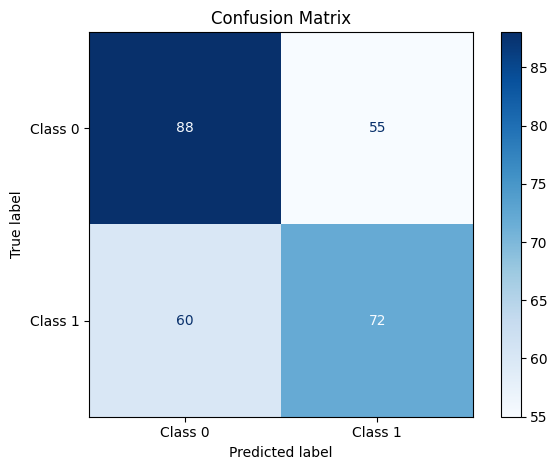

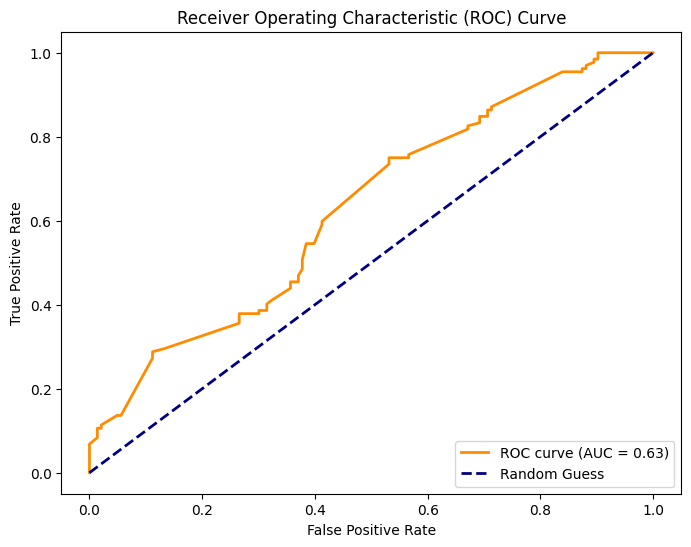

In [ ]:
import pandas as pd
import random
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# 1. 데이터 로드 및 전처리
file_path = '/content/drive/MyDrive/Halitosis/241121_Halitosis_data preprocessing.xlsx'  # 엑셀 파일 경로
data = pd.read_excel(file_path)

# 특징 및 타겟 설정
X = data[['O_RAU', 'S_Rheumatism', 'M_Hyperlipidemia', 'UFR' ]]  # 입력 특징
y = data['Halitosis_subjective']  # 타겟 레이블


# SMOTE 적용
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensor 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# 2. 트랜스포머 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, 64)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=num_heads, batch_first=True, dropout=0.1)  # Dropout 추가
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.input_layer(x).unsqueeze(1)
        x = self.transformer(x).squeeze(1)
        x = self.output_layer(x)
        return torch.sigmoid(x)

# 3. 모델 초기화
model = TransformerModel(input_dim=X_train.shape[1], num_heads=4, num_layers=2)

# Learning Rate Scheduler 추가
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 클래스 가중치 계산
class_weights = torch.tensor([1.0, len(y_train) / sum(y_train)])
criterion = nn.BCELoss()  # 클래스 가중치 사용

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 4. 학습 및 평가
best_auc = 0
patience = 10
counter = 0

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test).squeeze()
        auc_score = roc_auc_score(y_test.numpy(), test_outputs.numpy())
        predictions = (test_outputs >= 0.5).float()
        accuracy = accuracy_score(y_test.numpy(), predictions.numpy())

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, AUC: {auc_score:.4f}, Accuracy: {accuracy:.4f}")

    # Early Stopping
    if auc_score > best_auc:
        best_auc = auc_score
        counter = 0  # Reset counter
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# 5. Confusion Matrix 출력
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

# Confusion Matrix 시각화
cm = confusion_matrix(y_test.numpy(), predictions.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()  # 추가하여 그래프 표시 문제 해결
plt.show()

from sklearn.metrics import auc as sklearn_auc  # 'auc' 이름 충돌 방지

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test.numpy(), test_outputs.numpy())  # 실제 레이블과 예측 확률
roc_auc = sklearn_auc(fpr, tpr)  # sklearn의 'auc' 함수 명시적 호출

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


# 모델 전체 저장
#torch.save(model, '/content/drive/MyDrive/Halitosis/halitosis_model.pth')



# 스케일러 저장
#joblib.dump(scaler, '/content/drive/MyDrive/Halitosis/scaler.pkl')

In [ ]:
import torch
import pandas as pd

# 모델 로드
loaded_model = torch.load('/content/drive/MyDrive/Halitosis/halitosis_model.pth')  # PyTorch 모델 로드
loaded_model.eval()  # 평가 모드로 설정

# 외부 입력 데이터 예시
input_data = {
    'Sex': 1,                # Female
    'Age': 30,
    'Elderly': 0,
    'Super_Elderly': 0,
    'Xerostomia_subjective': 1,
    'UFR': 1,
    'SFR': 0.9,
    'pH': 6.2,
    'BufferCapacity': 4,
    'VAS': 5,
    'StickySaliva': 1,
    'Oralhygiene': 1,
    'Calculus': 1,
}

# 입력 데이터를 DataFrame으로 변환
input_df = pd.DataFrame([input_data])

# 데이터 정규화 (모델 학습 시 사용한 스케일러 적용 필요)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_input = scaler.fit_transform(input_df)  # fit_transform 대신 모델 학습 시 사용한 scaler를 load하여 transform 사용

# Tensor로 변환
input_tensor = torch.tensor(scaled_input, dtype=torch.float32)

# 예측 수행
with torch.no_grad():
    probabilities = loaded_model(input_tensor).squeeze().numpy()  # 예측 확률 계산
    predicted_label = (probabilities >= 0.5).astype(int)          # 0.5를 기준으로 이진 분류

# 출력
print(f"구취 확률: {probabilities * 100:.2f}%")
print(f"예측: {'구취 있음' if predicted_label == 1 else '구취 없음'}")


<ipython-input-6-920246afd359>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('/content/drive/MyDrive/Halitosis/halitosis_model.pth')  # PyTorch 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x13 and 48x64)

In [ ]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

# 모델 및 스케일러 로드
loaded_model = torch.load('/content/drive/MyDrive/Halitosis/halitosis_model.pth')  # 모델 로드
loaded_model.eval()  # 평가 모드 설정
scaler = joblib.load('/content/drive/MyDrive/Halitosis/scaler.pkl')  # 스케일러 로드

# CLI를 통해 사용자 입력 받기
print("구취 예측을 위한 데이터를 입력하세요.")
input_data = {}
input_data['Sex'] = int(input("성별 (0: 남성, 1: 여성): "))
input_data['Age'] = int(input("나이: "))
input_data['Elderly'] = int(input("노인 여부 (0: 아님, 1: 노인): "))
input_data['Super_Elderly'] = int(input("고령 여부 (0: 아님, 1: 고령): "))
input_data['Xerostomia_subjective'] = int(input("구강 건조 여부 (0: 없음, 1: 있음): "))
input_data['UFR'] = float(input("비자극 타액 분비율 (UFR): "))
input_data['SFR'] = float(input("자극 타액 분비율 (SFR): "))
input_data['pH'] = float(input("타액의 pH: "))
input_data['BufferCapacity'] = float(input("구강 완충능력: "))
input_data['VAS'] = int(input("VAS 점수 (0~10): "))
input_data['StickySaliva'] = int(input("침 끈적임 여부 (0: 없음, 1: 있음): "))
input_data['Oralhygiene'] = int(input("구강 위생 (0: 불량, 1: 양호): "))
input_data['Calculus'] = int(input("치석 여부 (0: 없음, 1: 있음): "))

# 입력 데이터를 DataFrame으로 변환
input_df = pd.DataFrame([input_data], columns=[
    'Sex', 'Age', 'Elderly', 'Super_Elderly',
    'Xerostomia_subjective', 'UFR', 'SFR', 'pH',
    'BufferCapacity', 'VAS', 'StickySaliva',
    'Oralhygiene', 'Calculus'
])

# 데이터 정규화
scaled_input = scaler.transform(input_df)

# Tensor로 변환
input_tensor = torch.tensor(scaled_input, dtype=torch.float32)

# 예측 수행
with torch.no_grad():
    probabilities = loaded_model(input_tensor).squeeze().numpy()  # 예측 확률
    predicted_label = (probabilities >= 0.5).astype(int)  # 0.5 기준으로 이진 분류

# 출력

print(f"\n구취 확률: {probabilities * 100:.2f}%")
print(f"예측: {'구취 있음' if predicted_label == 1 else '구취 없음'}")


<ipython-input-35-57b6b0237e9e>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('/content/drive/MyDrive/Halitosis/halitosis_model.pth')  # 모델 로드


구취 예측을 위한 데이터를 입력하세요.
성별 (0: 남성, 1: 여성): 1
나이: 40
노인 여부 (0: 아님, 1: 노인): 0
고령 여부 (0: 아님, 1: 고령): 0
구강 건조 여부 (0: 없음, 1: 있음): 0
비자극 타액 분비율 (UFR): 0.4
자극 타액 분비율 (SFR): 1.6
타액의 pH: 6.6
구강 완충능력: 12
VAS 점수 (0~10): 4
침 끈적임 여부 (0: 없음, 1: 있음): 0
구강 위생 (0: 불량, 1: 양호): 1
치석 여부 (0: 없음, 1: 있음): 1

구취 확률: 75.29%
예측: 구취 있음


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Epoch 1, Loss: 0.8261, AUC: 0.5946
Epoch 2, Loss: 0.6625, AUC: 0.7465
Epoch 3, Loss: 0.5802, AUC: 0.7844
Epoch 4, Loss: 0.5294, AUC: 0.8142
Epoch 5, Loss: 0.5024, AUC: 0.8362
Epoch 6, Loss: 0.4726, AUC: 0.8487
Epoch 7, Loss: 0.4531, AUC: 0.8561
Epoch 8, Loss: 0.4415, AUC: 0.8606
Epoch 9, Loss: 0.4372, AUC: 0.8647
Epoch 10, Loss: 0.4260, AUC: 0.8672


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ut


Feature Importances:
O_RAU: 0.0345
S_Rheumatism: 0.0196
M_Hyperlipidemia: 0.0170
UFR: 0.0165
O_LichenPlanus: 0.0119
S_MentalDisorders: 0.0116
M_Anxiolytic: 0.0114
S_TD: 0.0110
S_RenalDiseases: 0.0093
M_Osteoporosis: 0.0092
S_Hyperlipidemia: 0.0091
M_SleepingPills: 0.0091
O_Candidiasis: 0.0074
O_Glossodynia: 0.0056
S_Osteoporosis: 0.0056
S_CancerOp: 0.0056
S_Asthma: 0.0055
M_Aspirin: 0.0053
S_DM: 0.0051
Sex: 0.0035
M_GI: 0.0032
M_CV: 0.0030
Oralhygiene: 0.0023
M_DM: 0.0022
M_TD: 0.0018
S_LiverDiseases: 0.0010
S_Hypertension: 0.0006
Calculus: 0.0006
pH: 0.0005
S_UrinaryDiseases: 0.0004
M_Arthritis: 0.0004
NumberofSystmicDiseases: 0.0004
BufferCapacity: 0.0001
VAS: 0.0000
M_Rheumatism: 0.0000
Age: 0.0000
O_Sialodochitis: 0.0000
M_Hypertension: -0.0002
Elderly: -0.0007
O_Stomatitis: -0.0010
M_UrinaryDiseases: -0.0016
O_BMS: -0.0016
SFR: -0.0018
StickySaliva: -0.0022
O_Periodontitis: -0.0025
Super_Elderly: -0.0028
Xerostomia_subjective: -0.0062
S_CVD: -0.0064


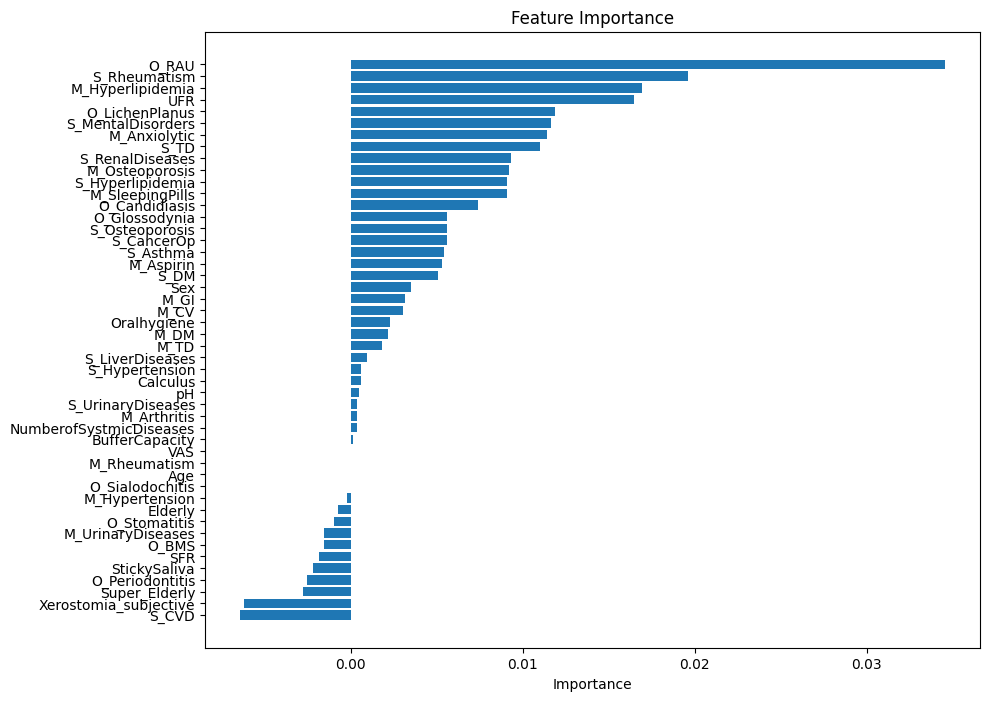

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# 데이터 로드 및 전처리
file_path = '/content/drive/MyDrive/Halitosis/241121_Halitosis_data preprocessing.xlsx'
data = pd.read_excel(file_path)

# 입력 특징 및 타겟 설정
X = data[['Sex', 'Age', 'Elderly', 'Super_Elderly', 'Xerostomia_subjective', 'UFR', 'SFR', 'pH', 'BufferCapacity',
          'VAS', 'StickySaliva', 'Oralhygiene', 'Calculus', 'O_Stomatitis', 'O_RAU', 'O_Candidiasis', 'O_Periodontitis',
          'O_LichenPlanus', 'O_Sialodochitis', 'O_Glossodynia', 'O_BMS', 'S_Hypertension', 'S_DM', 'S_Hyperlipidemia',
          'S_RenalDiseases', 'S_LiverDiseases', 'S_Rheumatism', 'S_Osteoporosis', 'S_CVD', 'S_TD', 'S_MentalDisorders',
          'S_UrinaryDiseases', 'S_Asthma', 'S_CancerOp', 'NumberofSystmicDiseases', 'M_Hypertension', 'M_DM',
          'M_Osteoporosis', 'M_Hyperlipidemia', 'M_CV', 'M_TD', 'M_GI', 'M_UrinaryDiseases', 'M_Arthritis',
          'M_Rheumatism', 'M_Anxiolytic', 'M_SleepingPills', 'M_Aspirin']]
y = data['Halitosis_subjective']

# SMOTE 적용
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensor 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# 트랜스포머 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, 64)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=num_heads, batch_first=True, dropout=0.1)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.input_layer(x).unsqueeze(1)
        x = self.transformer(x).squeeze(1)
        x = self.output_layer(x)
        return torch.sigmoid(x)

# 모델 초기화
model = TransformerModel(input_dim=X_train.shape[1], num_heads=4, num_layers=2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

# 모델 학습
for epoch in range(10):  # Epoch 수는 테스트를 위해 10으로 설정
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test).squeeze()
        auc_score = roc_auc_score(y_test.numpy(), test_outputs.numpy())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, AUC: {auc_score:.4f}")

# Scikit-learn 호환 래퍼 클래스 정의
class SklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler

    def fit(self, X, y):
        pass  # PyTorch 모델은 이미 학습된 상태이므로 fit은 필요 없음

    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
        with torch.no_grad():
            probabilities = self.model(X_tensor).squeeze().numpy()
        return np.vstack([1 - probabilities, probabilities]).T

    def predict(self, X):
        return self.predict_proba(X)[:, 1] >= 0.5

# 모델을 래핑
wrapped_model = SklearnWrapper(model, scaler)

# Permutation Importance 계산
perm_importance = permutation_importance(
    wrapped_model,
    X_test.numpy(),  # NumPy 변환
    y_test.numpy(),  # NumPy 변환
    n_repeats=30,
    random_state=42
)

# 변수 중요도 출력 및 시각화
importance_means = perm_importance.importances_mean
sorted_idx = np.argsort(importance_means)[::-1]

print("\nFeature Importances:")
for i in sorted_idx:
    print(f"{X.columns[i]}: {importance_means[i]:.4f}")

plt.figure(figsize=(10, 8))
plt.barh([X.columns[i] for i in sorted_idx], importance_means[sorted_idx])
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

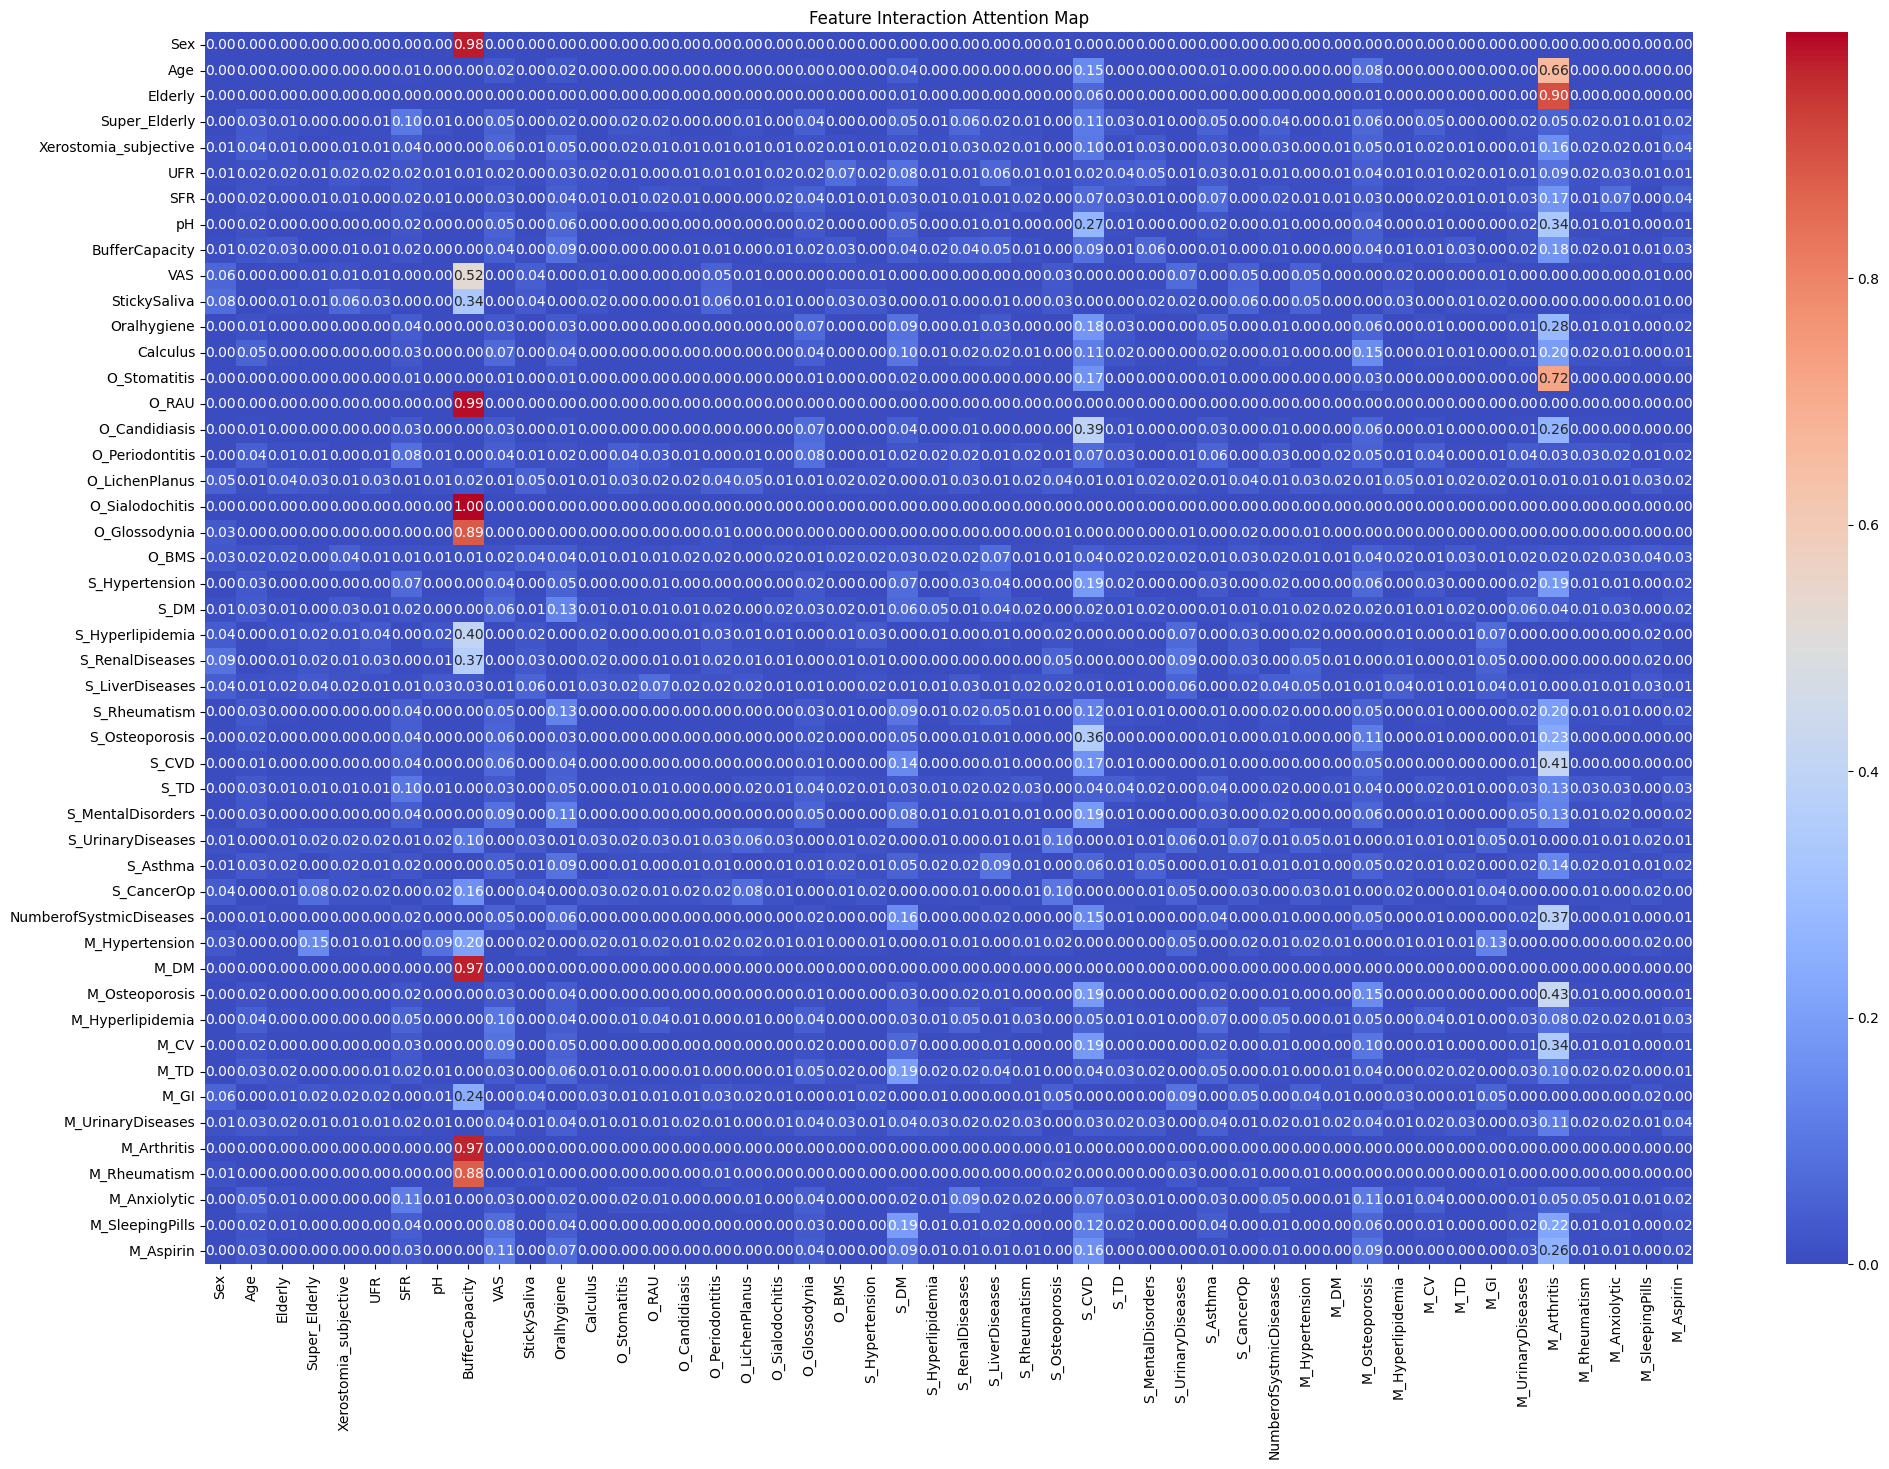

In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import random

# 난수 고정 함수
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # 난수 고정

# 1. 데이터 로드
# 엑셀 파일 경로와 Feature 설정
excel_path = "/content/drive/MyDrive/Halitosis/241121_Halitosis_data preprocessing.xlsx"  # 엑셀 파일 경로

features = ['Sex', 'Age', 'Elderly', 'Super_Elderly', 'Xerostomia_subjective', 'UFR', 'SFR', 'pH', 'BufferCapacity',
          'VAS', 'StickySaliva', 'Oralhygiene', 'Calculus', 'O_Stomatitis', 'O_RAU', 'O_Candidiasis', 'O_Periodontitis',
          'O_LichenPlanus', 'O_Sialodochitis', 'O_Glossodynia', 'O_BMS', 'S_Hypertension', 'S_DM', 'S_Hyperlipidemia',
          'S_RenalDiseases', 'S_LiverDiseases', 'S_Rheumatism', 'S_Osteoporosis', 'S_CVD', 'S_TD', 'S_MentalDisorders',
          'S_UrinaryDiseases', 'S_Asthma', 'S_CancerOp', 'NumberofSystmicDiseases', 'M_Hypertension', 'M_DM',
          'M_Osteoporosis', 'M_Hyperlipidemia', 'M_CV', 'M_TD', 'M_GI', 'M_UrinaryDiseases', 'M_Arthritis',
          'M_Rheumatism', 'M_Anxiolytic', 'M_SleepingPills', 'M_Aspirin']  # 사용할 Feature 리스트

target_column = "Halitosis_subjective"  # 타겟 변수 이름


# 데이터 불러오기
data = pd.read_excel(excel_path)

# Feature와 Target 분리
X = data[features]
y = data[target_column]

# Feature 정규화
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_tensor = torch.tensor(X_normalized, dtype=torch.float32)

# Target 텐서 변환
if len(y.shape) == 1:
    y_tensor = torch.tensor(y.values, dtype=torch.long)
else:
    y_tensor = torch.tensor(y.values, dtype=torch.long).squeeze()

# Self-Attention 구현
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Query, Key, Value 계산
        Q = self.query(x)  # (batch_size, input_dim)
        K = self.key(x)    # (batch_size, input_dim)
        V = self.value(x)  # (batch_size, input_dim)

        # Attention Score 계산 (Feature 간 관계)
        attention_scores = torch.matmul(Q.T, K) / np.sqrt(Q.shape[1])  # (input_dim, input_dim)
        attention_weights = self.softmax(attention_scores)  # (input_dim, input_dim)

        # Attention 적용
        attended_output = torch.matmul(attention_weights, V.T).T  # (batch_size, input_dim)
        return attended_output, attention_weights

# Self-Attention 모델 초기화
input_dim = X_tensor.shape[1]  # Feature 수에 기반
attention_model = SelfAttention(input_dim)

# 평가 모드 설정
attention_model.eval()

# Attention 계산
with torch.no_grad():
    _, attention_weights = attention_model(X_tensor)

# Attention 맵을 numpy 배열로 변환
attention_weights_np = attention_weights.numpy()  # (input_dim, input_dim)

# Feature 크기와 Attention Map 확인
assert attention_weights_np.shape[0] == len(features), f"Feature 수({len(features)})와 Attention Map 차원({attention_weights_np.shape[0]})이 일치하지 않습니다."

# Attention 맵 시각화
plt.figure(figsize=(24, 16))
sns.heatmap(
    attention_weights_np,
    annot=True,
    fmt=".2f",
    xticklabels=features,
    yticklabels=features,
    cmap="coolwarm"
)
plt.title("Feature Interaction Attention Map")
plt.show()


큰 Attention 값을 가지는 두 변수:
1. O_Sialodochitis
2. BufferCapacity
Attention Score: 0.9996


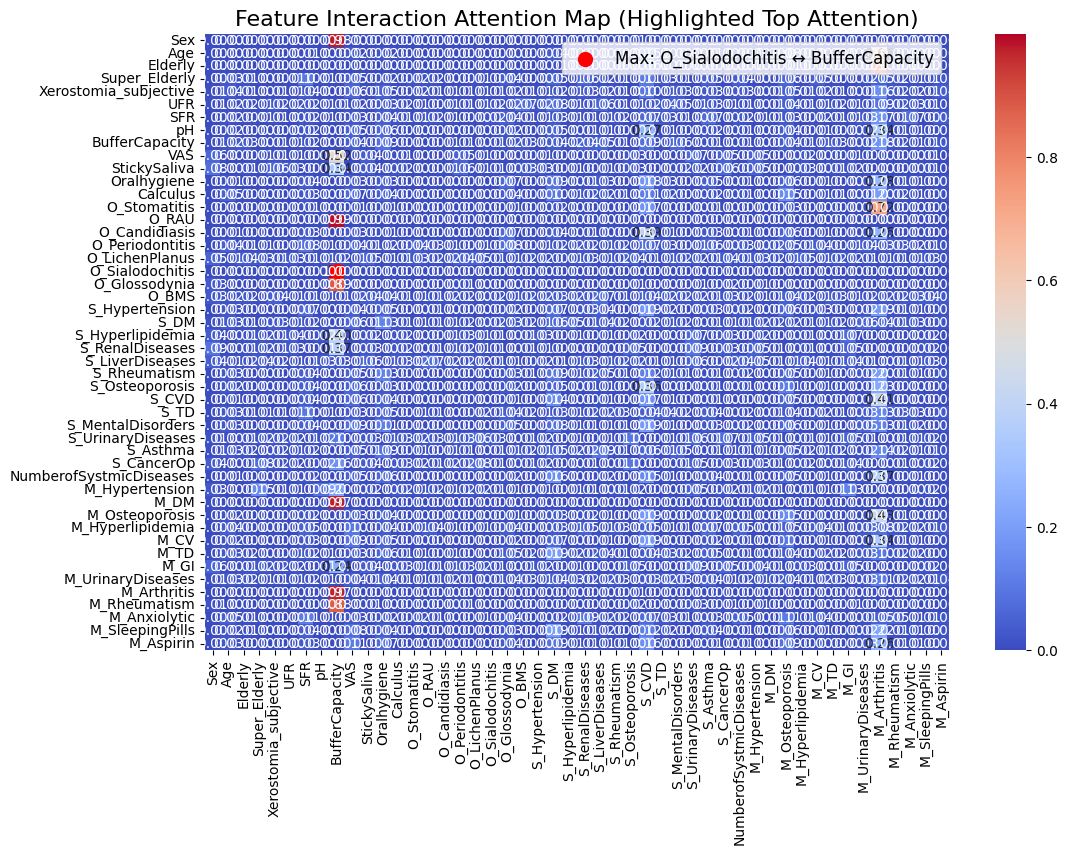

In [14]:
# 큰 Attention 값을 가지는 두 변수를 확인하는 코드
# attention_weights_np는 Attention Weight 행렬
# features는 Feature 이름 리스트

# 1. Attention Weight에서 가장 큰 값과 해당 인덱스 찾기
max_value = np.max(attention_weights_np)  # 최대 Attention 값
max_indices = np.unravel_index(np.argmax(attention_weights_np), attention_weights_np.shape)  # 최대 값의 인덱스

# 2. Feature 이름과 값 출력
feature_1 = features[max_indices[0]]
feature_2 = features[max_indices[1]]

print(f"큰 Attention 값을 가지는 두 변수:")
print(f"1. {feature_1}")
print(f"2. {feature_2}")
print(f"Attention Score: {max_value:.4f}")

# 3. 상위 Attention 값을 시각적으로 강조한 Heatmap 생성
plt.figure(figsize=(12, 8))
sns.heatmap(
    attention_weights_np,
    annot=True,
    fmt=".2f",
    xticklabels=features,
    yticklabels=features,
    cmap="coolwarm"
)
plt.title("Feature Interaction Attention Map (Highlighted Top Attention)", fontsize=16)
plt.scatter(max_indices[1] + 0.5, max_indices[0] + 0.5, color='red', s=100, label=f"Max: {feature_1} ↔ {feature_2}")
plt.legend(loc="upper right", fontsize=12)
plt.show()


Feature Importance Ranking:
                    Feature  Importance
18          O_Sialodochitis    0.020383
14                    O_RAU    0.019908
0                       Sex    0.019529
36                     M_DM    0.019306
43              M_Arthritis    0.019142
2                   Elderly    0.016675
19            O_Glossodynia    0.015955
44             M_Rheumatism    0.015769
13             O_Stomatitis    0.010976
1                       Age    0.009225
9                       VAS    0.005714
37           M_Osteoporosis    0.004668
15            O_Candidiasis    0.004520
28                    S_CVD    0.004392
27           S_Osteoporosis    0.003888
7                        pH    0.003757
34  NumberofSystmicDiseases    0.003678
23         S_Hyperlipidemia    0.003365
39                     M_CV    0.003318
24          S_RenalDiseases    0.003013
10             StickySaliva    0.002486
11              Oralhygiene    0.002408
47                M_Aspirin    0.002244
46          

<ipython-input-19-f63849bedfbd>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


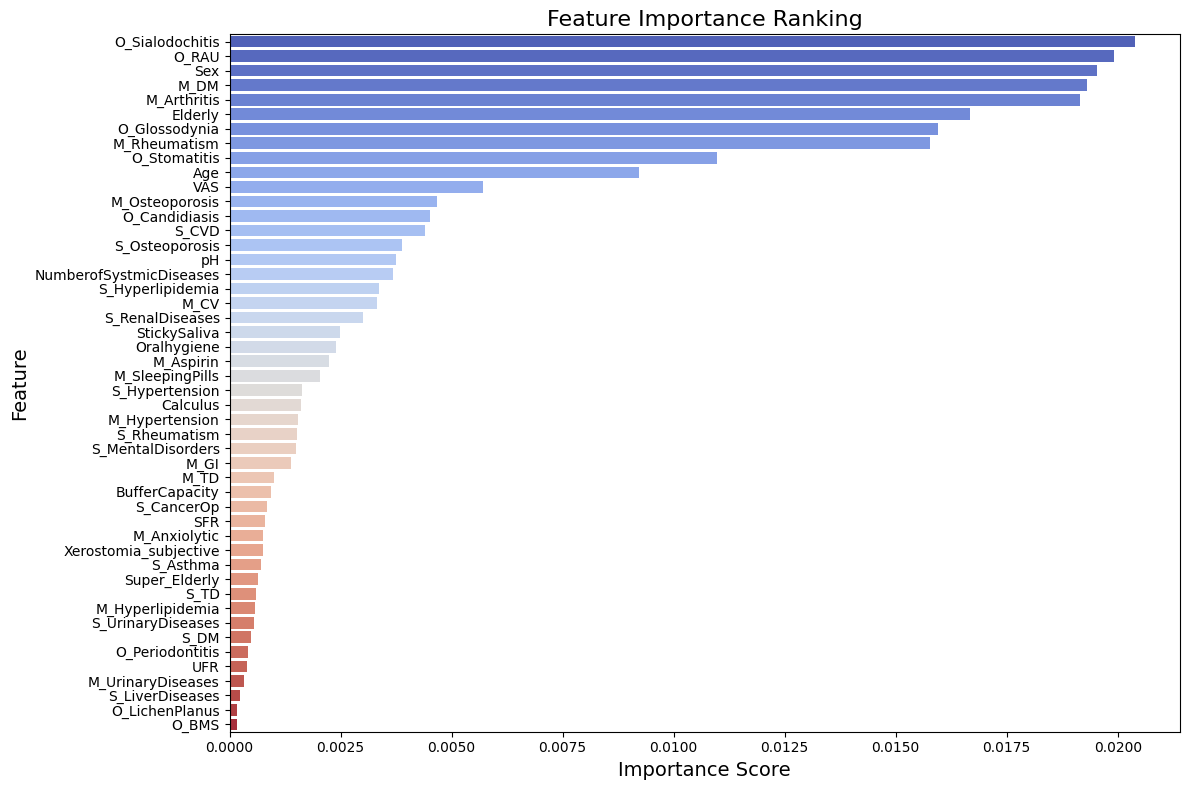

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance 계산 (분산 기반)
feature_importance = np.var(attention_weights_np, axis=1)  # 분산 계산

# Feature Ranking 생성
feature_ranking = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

# Feature Importance 출력
print("Feature Importance Ranking:")
print(feature_ranking)

# Feature Ranking 시각화
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_ranking,
    palette="coolwarm"
)
plt.title("Feature Importance Ranking", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()


Feature-Target Correlation:
                    Feature  Correlation
13             O_Stomatitis     0.075470
42        M_UrinaryDiseases     0.058485
4     Xerostomia_subjective     0.050147
37           M_Osteoporosis     0.044861
24          S_RenalDiseases     0.033107
39                     M_CV     0.030263
33               S_CancerOp     0.027081
47                M_Aspirin     0.024887
27           S_Osteoporosis     0.015036
28                    S_CVD     0.009034
7                        pH     0.006669
25          S_LiverDiseases     0.004763
43              M_Arthritis     0.001398
16          O_Periodontitis    -0.004585
46          M_SleepingPills    -0.011625
10             StickySaliva    -0.012234
11              Oralhygiene    -0.012552
35           M_Hypertension    -0.012847
9                       VAS    -0.020110
30        S_MentalDisorders    -0.020825
20                    O_BMS    -0.027124
0                       Sex    -0.027799
44             M_Rheumatism  

<ipython-input-34-80912b1e18f3>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


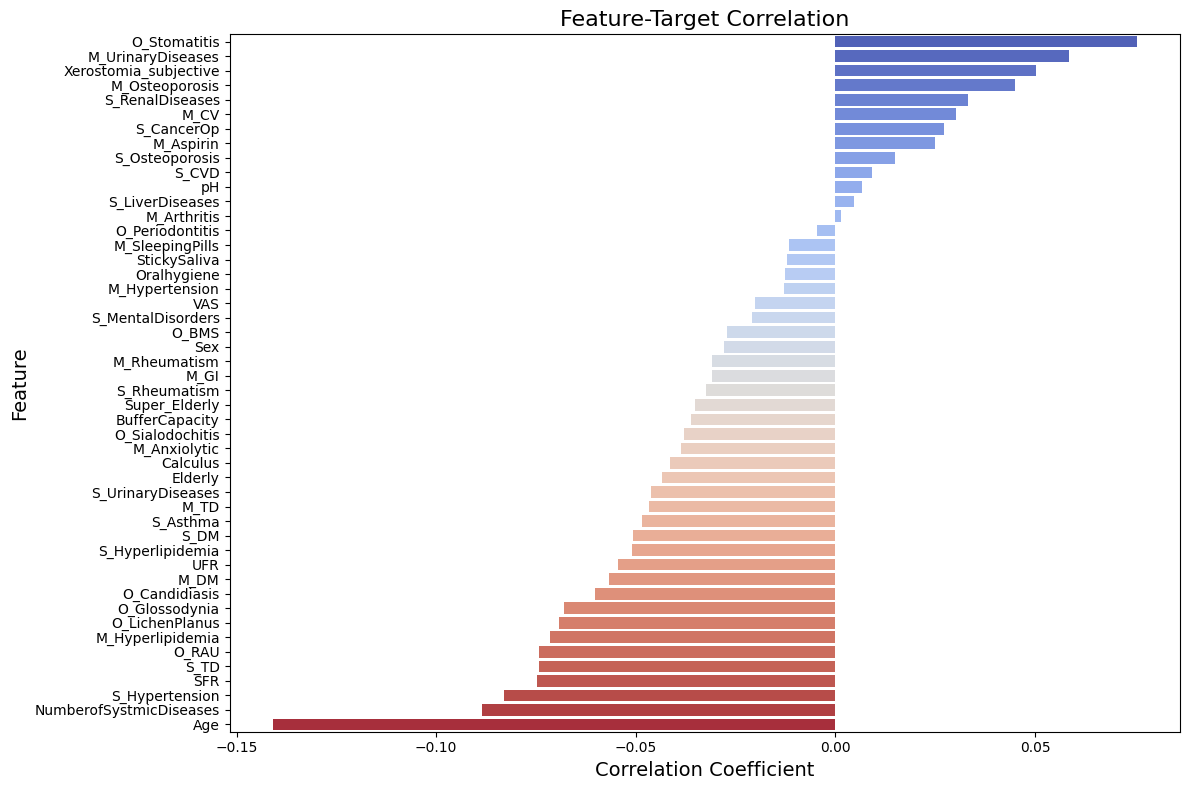

In [34]:
# 상관성 분석
correlations = []
for feature in features:
    corr = np.corrcoef(X[feature], y)[0, 1]
    correlations.append(corr)

# 상관계수 테이블 생성
correlation_df = pd.DataFrame({
    "Feature": features,
    "Correlation": correlations
}).sort_values(by="Correlation", ascending=False)

print("Feature-Target Correlation:")
print(correlation_df)

plt.figure(figsize=(12, 8))
sns.barplot(
    x="Correlation",
    y="Feature",
    data=correlation_df,
    palette="coolwarm"
)
plt.title("Feature-Target Correlation", fontsize=16)
plt.xlabel("Correlation Coefficient", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()


Top 10 Feature Pairs with High Attention Scores:
          Feature 1       Feature 2  Attention Score
0   O_Sialodochitis  BufferCapacity         0.999617
1             O_RAU  BufferCapacity         0.988127
2               Sex  BufferCapacity         0.978855
3              M_DM  BufferCapacity         0.973382
4       M_Arthritis  BufferCapacity         0.969294
5           Elderly     M_Arthritis         0.903776
6     O_Glossodynia  BufferCapacity         0.885956
7      M_Rheumatism  BufferCapacity         0.880936
8      O_Stomatitis     M_Arthritis         0.718815
9               Age     M_Arthritis         0.658176
10              VAS  BufferCapacity         0.524505


<ipython-input-31-9e9d9a057e4b>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


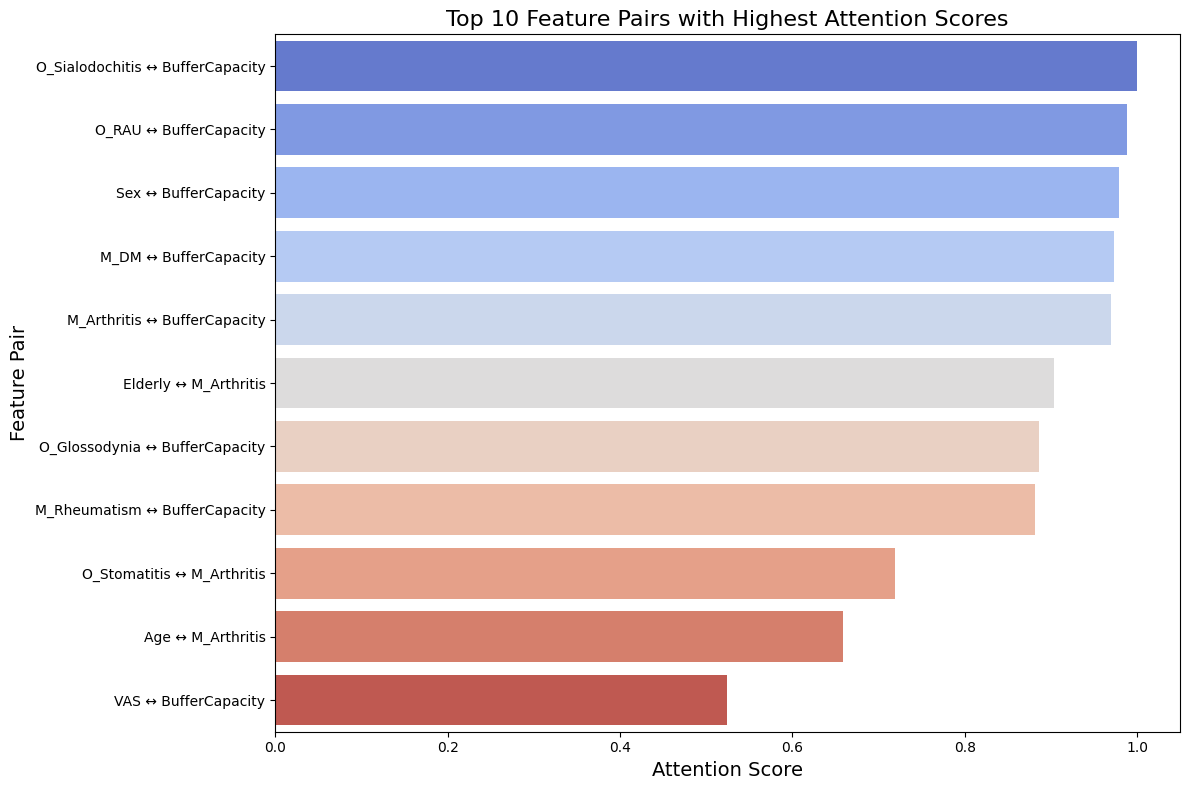

In [31]:
# Attention Weight 행렬에서 상위 10개의 Feature 쌍을 추출
num_top_pairs = 11

# Attention Weight 행렬을 1차원으로 변환하여 정렬
attention_scores_flat = attention_weights_np.flatten()
sorted_indices = np.argsort(-attention_scores_flat)  # 내림차순 정렬

# 상위 Attention Score와 해당 인덱스 추출
top_scores = attention_scores_flat[sorted_indices[:num_top_pairs]]
top_indices = [np.unravel_index(idx, attention_weights_np.shape) for idx in sorted_indices[:num_top_pairs]]

# Feature 이름과 Attention Score 저장
top_feature_pairs = [
    {
        "Feature 1": features[idx[0]],
        "Feature 2": features[idx[1]],
        "Attention Score": score
    }
    for idx, score in zip(top_indices, top_scores)
]

# 결과를 데이터프레임으로 변환
top_feature_pairs_df = pd.DataFrame(top_feature_pairs)

# 출력
print("Top 10 Feature Pairs with High Attention Scores:")
print(top_feature_pairs_df)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Attention Score",
    y=["{} ↔ {}".format(row["Feature 1"], row["Feature 2"]) for _, row in top_feature_pairs_df.iterrows()],
    data=top_feature_pairs_df,
    palette="coolwarm"
)
plt.title("Top 10 Feature Pairs with Highest Attention Scores", fontsize=16)
plt.xlabel("Attention Score", fontsize=14)
plt.ylabel("Feature Pair", fontsize=14)
plt.tight_layout()
plt.show()


In [28]:
# 상관관계 분석
for pair in top_feature_pairs:
    feature_1 = pair["Feature 1"]
    feature_2 = pair["Feature 2"]
    correlation = np.corrcoef(X[feature_1], X[feature_2])[0, 1]
    print(f"Correlation between {feature_1} and {feature_2}: {correlation:.4f}")


Correlation between O_Sialodochitis and BufferCapacity: -0.0110
Correlation between O_RAU and BufferCapacity: -0.0061
Correlation between Sex and BufferCapacity: -0.0793
Correlation between M_DM and BufferCapacity: 0.0384
Correlation between M_Arthritis and BufferCapacity: 0.0043
Correlation between Elderly and M_Arthritis: 0.0092
Correlation between O_Glossodynia and BufferCapacity: -0.0553
Correlation between M_Rheumatism and BufferCapacity: 0.0063
Correlation between O_Stomatitis and M_Arthritis: 0.0319
Correlation between Age and M_Arthritis: 0.0770
